In [154]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots
from parse_nga import *
from numba import jit, njit, vectorize
import nbkode

In [155]:
plt.style.use(['science', 'notebook', 'grid'])
fig_size = (18,9)
fig_format = 'svg'

Define system parameters

In [156]:
mt, mb, mf, I = 5347.31, 9558.72, 9558.72, 89397.05
Ts, Tb, dampb, damps = 0.1, 100.0, 0.0, 0.05
h = 2.2
mu = 0.15
g = 9.81
eps = 10000.0
kb = (mt + mb) * (2*np.pi/Tb) **2
cb = 2*dampb*(mt + mb)*2*np.pi/Tb
kt = mt * (2*np.pi/Ts) **2
ct = 2*damps*mt*2*np.pi/Ts

In [157]:
kb

58.846647716308

In [158]:
kt

21110333.723995656

Implement functions for soil constants based on ASCE 4-16

In [159]:
betax_f = interp1d([1.0, 1.5, 2.0, 3.0, 4.0], [0.5, 0.46, 0.46, 0.48, 0.5], kind='linear')
betaphi_f = interp1d([1.0, 1.5, 2.0, 3.0, 4.0], [0.5, 0.55, 0.6, 0.69, 0.78], kind = 'linear')

In [160]:
def soil_constants_f(B, L, poisson, shear_vel, density):
    span_ratio = L/B
    shear_modulus = shear_vel**2 * density
    kx = 2*(1+poisson)*shear_modulus*betax_f(span_ratio)*np.sqrt(B*L)
    kphi = (shear_modulus/(1-poisson))*betaphi_f(span_ratio)*B*L**2
    Rx = np.sqrt(B*L/np.pi)
    cx = 0.576*kx*Rx*np.sqrt(density/shear_modulus)
    Rphi = (B*L**3 / (3*np.pi))**0.25
    Bphi = 3*(1-poisson)*I / (8*density*Rphi**5)
    cphi = (0.3/(1+Bphi))*kphi*Rphi*np.sqrt(density/shear_modulus)
    return [kx, kphi, cx, cphi]

Define soil and foundation parameters

In [161]:
breadth , length , nu , vs, rho = 7.0, 9.5, 0.3, 100, 1800
kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vs, rho)

In [162]:
kh

179917155.2211104

Define all matrices in the following equation of motion:
$$M\ddot{u} + C\dot{u} + Ku + F_f*sgn(\dot{u}) = -Mr\ddot{u_g}$$
$M=
\begin{bmatrix}
m_t & 0 & m_t & m_th\\
0 & m_b & m_b & 0 \\
m_t & m_b & m_t+m_b+m_f & m_th\\
m_th &  0 & m_th & m_th^2 + I_f\\
\end{bmatrix}$,
$ C=
\begin{bmatrix}
c_t & -c_t & 0 & 0\\
-c_t & c_b+c_t & 0 & 0\\
0 & 0 & c_h & 0 \\
0 & 0 & 0 &c_\phi\\
\end{bmatrix}$,
$K=
\begin{bmatrix}
k_t & -k_t & 0 & 0 \\
-k_t & k_b+k_t & 0 & 0\\
0 & 0 & k_h & 0 \\
0 & 0 & 0 & k_\phi\\
\end{bmatrix}$,
$ F_f= \mu(m_b+m_t)g
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
\end{bmatrix}$ and
$ r = 
\begin{bmatrix}
0\\ 0\\ 1\\ 0 \end{bmatrix} $

Here, $$sgn(\dot{u}) = \frac{2}{\pi} \arctan( \epsilon \dot{u}) $$

In [163]:
M = np.array([[mt, 0, mt, mt*h],
              [0, mb, mb, 0],
              [mt, mb, mt+mb+mf, mt*h],
              [mt*h, 0, mt*h, mt*h**2 + I]])

In [164]:
M

array([[  5347.31  ,      0.    ,   5347.31  ,  11764.082 ],
       [     0.    ,   9558.72  ,   9558.72  ,      0.    ],
       [  5347.31  ,   9558.72  ,  24464.75  ,  11764.082 ],
       [ 11764.082 ,      0.    ,  11764.082 , 115278.0304]])

In [165]:
C = np.array([[ct, -ct, 0, 0],
              [-ct, cb+ct, 0, 0],
              [0, 0, ch, 0],
              [0, 0, 0, cp]])
K = np.array([[kt, -kt, 0, 0],
              [-kt, kb+kt, 0, 0],
              [0, 0, kh, 0],
              [0, 0, 0, kp]])
Ff = np.array([np.zeros(4),
               [0, mu*(mb+mt)*g, 0, 0],
               np.zeros(4),
               np.zeros(4)])
r = np.array([0, 0, 1, 0])

Define a state space model with state vector $X = [ u_t,u_b, u_h, \phi, \dot{u_t}, \dot{u_b}, \dot{u_h}, \dot{\phi} ]^T 
                                                    = \begin{bmatrix} u \\ \dot{u} \end{bmatrix} $

The state space equations that are based on the equations of motions can be written as:
$$ \dot{X} = AX + g(X) + B\ddot{u_g}$$

where, 

$$A = \begin{bmatrix} 0_{4 \times 4} & I_{4 \times 4} \\ -M^{-1}K & -M^{-1}C \end{bmatrix}$$

$$g(X) = \dfrac{2}{\pi} \begin{bmatrix} 0_{4 \times 4} & 0_{4 \times 4} \\ 0_{4 \times 4} & -M^{-1}F_f \end{bmatrix} \arctan (\epsilon X) $$

$$B = \begin{bmatrix} 0_{4 \times 1} \\ - r \end{bmatrix}$$

Here, $\ddot{u_g}$ is the ground acceleration

In [166]:
M_inv = np.linalg.inv(M)

In [167]:
A11 = np.zeros([4,4])
A12 = np.eye(4)
A21 = - M_inv @ K
A22 = - M_inv @ C

In [168]:
A = np.block([[A11, A12],
              [A21, A22]])

In [169]:
G11 = np.zeros([4,4])
G22 = - M_inv @ Ff

In [170]:
G = 2.0 / np.pi * np.block([[G11, G11],
                            [G11, G22]])

In [171]:
# G21 = - mu*g*(mt+mb)* M_inv @ np.array([0, 1, 0, 0]).reshape([4,1])
# G = 2.0 / np.pi * np.vstack([np.zeros([4,1]), G21])

In [172]:
B11 = np.zeros(4)

In [173]:
B = np.hstack([B11, -r]).reshape([8,1])

In [174]:
B

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-1.],
       [ 0.]])

In [175]:
#G0 = np.hstack([np.zeros(4), - 2.0 / np.pi * mu* (mb+mt) * g * M_inv@r])

Implement state space equations and define functions to solve them

In [176]:
def dXdt(t, X):
    # return (A@X + G@np.arctan(X) + B*ug_dd(t))
    # ug_dd = eq_f(t)
    ug_dd = np.interp(t, times, eq_acc)
    # return (A@X + G*np.arctan(eps*Bt@X) + B*ug_dd)
    return (A.dot(X) + G.dot(np.arctan(eps*X)) + B*ug_dd)

In [177]:
# init = 1e-100 * np.ones(8)
init = np.zeros(8)

In [178]:
def solve_eq(system, time_series):
    start, end = [time_series[0], time_series[-1]]
    ans = solve_ivp(system, (start,end), y0 = init, method = 'BDF', t_eval = time_series, 
                    rtol = 1e-5, atol = 1e-6, vectorized = True)
    soln = ans.y
    # print(f'RHS evaluations: {ans.nfev}, Jacobian evaluations: {ans.njev}, LU decomps: {ans.nlu}')
    # dxdt = system(time_series, soln)
    # acc = dxdt[-4:]
    # return (soln,acc)
    return soln

In [179]:
def get_acc(soln, time_series):
    dxdt = dXdt(time_series, soln)
    accel = dxdt[-4:]
    return accel

Plotting functions

In [180]:
def plot_one(ax, x, y, xlabel, ylabel, title, marker, legend=None):
    h1, = ax.plot(x, y, marker)
    if legend:
        ax.legend([h1], [legend])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)

In [181]:
def plot_two(ax, x, y, xlabel, ylabel, title, markers, legends):
    y1, y2 = y
    h1, = ax.plot(x, y1, markers[0])
    h2, = ax.plot(x, y2, markers[1])
    ax.legend([h1, h2], legends)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)

Read earthquake data and store it in a pandas dataframe

In [182]:
# eq_name = 'imp_valley_cc'
eq_type = 'near_fault'
#if not os.path.exists(eq_name):
    # os.mkdir(eq_name)
# file_name = eq_name + '.csv'

In [183]:
eq_df = pd.read_csv(os.path.join(eq_type, 'summary_eq.csv'))

In [184]:
eq_df.columns

Index(['Folder', ' Record Sequence Number', ' Mean Squared Error',
       ' Scale Factor', ' Tp-Pulse Period (sec)', ' 5-75% Duration (sec)',
       ' 5-95% Duration (sec)', ' Arias Intensity (m/sec)', ' Earthquake Name',
       ' Year', ' Station Name', ' Magnitude', ' Mechanism', ' Rjb (km)',
       ' Rrup (km)', ' Vs30 (m/sec)', ' Lowest Useable Frequency (Hz)',
       ' Initial-search Scale Factor', ' Horizontal-1 Acc. Filename',
       ' Horizontal-2 Acc. Filename', ' Vertical Acc. Filename'],
      dtype='object')

In [185]:
eq_df

,Folder,Record Sequence Number,Mean Squared Error,Scale Factor,Tp-Pulse Period (sec),5-75% Duration (sec),5-95% Duration (sec),Arias Intensity (m/sec),Earthquake Name,Year,...,Magnitude,Mechanism,Rjb (km),Rrup (km),Vs30 (m/sec),Lowest Useable Frequency (Hz),Initial-search Scale Factor,Horizontal-1 Acc. Filename,Horizontal-2 Acc. Filename,Vertical Acc. Filename
0,san_fernando,77,-,1,1.638,5.8,7.3,8.9,San Fernando,1971,...,6.61,Reverse,0.00,1.81,2016.13,0.0875,1,RSN77_SFERN_PUL164.AT2,RSN77_SFERN_PUL254.AT2,RSN77_SFERN_PULDWN.AT2
1,tabas_nf,143,-,1,6.188,8.3,16.5,11.8,Tabas_ Iran,1978,...,7.35,Reverse,1.79,2.05,766.77,0.1250,1,RSN143_TABAS_TAB-L1.AT2,RSN143_TABAS_TAB-T1.AT2,RSN143_TABAS_TAB-V1.AT2
2,landers_nf,879,-,1,5.124,8.4,13.8,7.0,Landers,1992,...,7.28,strike slip,2.19,2.19,1369.00,0.0000,1,RSN879_LANDERS_LCN260.AT2,RSN879_LANDERS_LCN345.AT2,RSN879_LANDERS_LCN-UP.AT2
3,northridge_1050,1050,-,1,0.588,2.0,4.3,0.9,Northridge-01,1994,...,6.69,Reverse,4.92,7.01,2016.13,0.1600,1,RSN1050_NORTHR_PAC175.AT2,RSN1050_NORTHR_PAC265.AT2,RSN1050_NORTHR_PAC-UP.AT2
4,northridge_1051,1051,-,1,0.840,3.8,6.0,8.7,Northridge-01,1994,...,6.69,Reverse,4.92,7.01,2016.13,0.1600,1,RSN1051_NORTHR_PUL104.AT2,RSN1051_NORTHR_PUL194.AT2,RSN1051_NORTHR_PUL-UP.AT2
5,kocaeli_geb_nf,1161,-,1,5.992,5.8,8.2,0.5,Kocaeli_ Turkey,1999,...,7.51,strike slip,7.57,10.92,792.00,0.1000,1,RSN1161_KOCAELI_GBZ000.AT2,RSN1161_KOCAELI_GBZ270.AT2,RSN1161_KOCAELI_GBZ-UP.AT2
6,kocaeli_iz_nf,1165,-,1,5.369,8.2,15.1,0.8,Kocaeli_ Turkey,1999,...,7.51,strike slip,3.62,7.21,811.00,0.1250,1,RSN1165_KOCAELI_IZT180.AT2,RSN1165_KOCAELI_IZT090.AT2,RSN1165_KOCAELI_IZT-UP.AT2
7,loma_prieta_nf,3548,-,1,1.568,2.1,4.3,1.9,Loma Prieta,1989,...,6.93,Reverse Oblique,3.22,5.02,1070.34,0.1000,1,RSN3548_LOMAP_LEX000.AT2,RSN3548_LOMAP_LEX090.AT2,RSN3548_LOMAP_LEX-UP.AT2
8,cape_mendocino,3744,-,1,5.362,3.6,13.4,0.6,Cape Mendocino,1992,...,7.01,Reverse,8.49,12.24,566.42,0.0000,1,RSN3744_CAPEMEND_BNH270.AT2,RSN3744_CAPEMEND_BNH360.AT2,RSN3744_CAPEMEND_BNH-UP.AT2
9,l_aquila,4483,-,1,1.981,5.0,11.6,1.2,L'Aquila_ Italy,2009,...,6.30,Normal,0.00,5.38,717.00,0.0250,1,RSN4483_L-AQUILA_AM043XTE.AT2,RSN4483_L-AQUILA_AM043YLN.AT2,RSN4483_L-AQUILA_AM043ZUP.AT2


In [186]:
pgas = np.zeros(10)
dom_periods = np.zeros(10)

Loop over all NF earthquakes

In [187]:
%%time
fig = plt.figure(figsize = fig_size)
ax = fig.add_subplot(111)
psd_nf = dict()
drift_nf = dict()
acc_nf = dict()
resid_nf = dict()
fix_psd_nf = dict()
fix_drift_nf = dict()
fix_acc_nf = dict()
fix_resid_nf = dict()
ssi_psd_nf = dict()
ssi_drift_nf = dict()
ssi_acc_nf = dict()
ssi_resid_nf = dict()
vs_psd_nf = dict()
vs_drift_nf = dict()
vs_acc_nf = dict()
vs_resid_nf = dict()
for index, row in eq_df.iterrows():
    eq_name = row['Folder']
    eq_title = f"{row[' Earthquake Name']} Record no. {row[' Record Sequence Number']}"
    if not os.path.exists(row['Folder']):
        os.mkdir(row['Folder'])
    h1 = row[' Horizontal-1 Acc. Filename'].strip()
    h2 = row[' Horizontal-2 Acc. Filename'].strip()
    print(f'{index}. {h1}')
    # print(h2)
    desc, npts, time_step, times, acc1 = processNGAfile(os.path.join(eq_type, h1))
    desc, npts, time_step, times, eq_acc = processNGAfile(os.path.join(eq_type, h2))
    if (np.max(acc1) > np.max(eq_acc)):
        eq_acc = acc1
    eq_acc *= g
    eq_actual = eq_acc
    max_eq = np.amax(abs(eq_actual))
    eq_norm = eq_actual / max_eq * g
    pgas[index] = max_eq
    #Plot time history
    plot_one(ax, times, eq_acc, 'Time(s)', 'Acceleration(m/s$^2$)', eq_title, '-')
    plt.savefig(os.path.join(eq_name,f'eq_time_history.{fig_format}'))
    plt.cla()
    #Plot FFT
    eq_fft = fft(eq_acc)
    eq_fft = np.abs(eq_fft)[0:npts//2]
    frq = fftfreq(npts,time_step)[0:npts//2]
    dominant_period = 2*np.pi/frq[np.argmax(eq_fft)]
    dom_periods[index] = dominant_period
    plot_one(ax, frq, eq_fft, 'Frequency (Hz)', 'Frequency Amplitude', eq_title, '-', legend = f'Predominant Time Period = {dominant_period:.2f}s')
    ax.set_xscale('log')
    plt.savefig(os.path.join(eq_name,f'eq_fft.{fig_format}'))
    plt.cla()
    #Solve for unscaled earthquake and save response history plots
    soln = solve_eq(dXdt, times)
    acc = get_acc(soln, times)
    plot_one(ax, times, soln[1], 'Time (s)', 'Base Displacement', eq_title, '-', legend = f'Residual Displacement = {soln[1,-1]:.6f} m')
    plt.savefig(os.path.join(eq_name, f'base_displacement.{fig_format}'))
    plt.cla()
    plot_one(ax, times, (soln[0]-soln[1])/h*100.0, 'Time(s)', 'IDR (%)', eq_title, '-')
    plt.savefig(os.path.join(eq_name, f'idr.{fig_format}'))
    plt.cla()
    plot_one(ax, times, (acc[0]+acc[2]+eq_acc), 'Time(s)', 'Absolute Roof Acceleration (m/s$^2$)', eq_title, '-')
    plt.savefig(os.path.join(eq_name, f'roof_acc.{fig_format}'))
    plt.cla()
    #Solve for 10 PGAs
    max_drift = np.zeros(10)
    max_acc = np.zeros(10)
    psd = np.zeros(10)
    residual = np.zeros(10)
    for i in range(10):
        eq_acc = eq_norm*(i+1)/10
        # print(np.amax(abs(eq_acc)))
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100.0
        max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        psd[i] = np.amax(abs(base_disp))
        residual[i] = ans[1,-1]
    psd_nf[row['Folder']] = psd
    drift_nf[row['Folder']] = max_drift
    acc_nf[row['Folder']] = max_acc
    resid_nf[row['Folder']] = residual
    factors = np.arange(0.1,1.1,0.1).round(1)
    #Solve for fixed base and save plots
    G = G*(100.0 / mu)
    fix_max_drift = np.zeros(10)
    fix_max_acc = np.zeros(10)
    fix_psd = np.zeros(10)
    fix_residual = np.zeros(10)
    for i in range(10):
        eq_acc = eq_norm*(i+1)/10
        # print(np.amax(abs(eq_acc)))
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100.0
        fix_max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        fix_max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        fix_psd[i] = np.amax(abs(base_disp))
        fix_residual[i] = ans[1,-1]
    fix_psd_nf[row['Folder']] = fix_psd
    fix_drift_nf[row['Folder']] = fix_max_drift
    fix_acc_nf[row['Folder']] = fix_max_acc
    fix_resid_nf[row['Folder']] = fix_residual
    plot_two(ax, factors, [fix_psd*1000, psd*1000], 'Scaled Peak Acceleration (g)', 'Peak Sliding Displacement (mm)',
             'PGA vs Base Displacement', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_psd.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [fix_max_drift, max_drift], 'Scaled Peak Acceleration (g)', 'Peak IDR (%)',
             'PGA vs Interstory Drift Ratio', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_idr.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [fix_max_acc, max_acc], 'Scaled Peak Acceleration (g)', 'Peak Absolute Roof Acceleration (m/s$^2$)',
             'PGA vs Absolute Roof Acceleration', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_acc.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [fix_residual*1000, residual*1000], 'Scaled Peak Acceleration (g)', 'Residual Displacement (mm)',
             'PGA vs Residual Displacement', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_resid.{fig_format}'))
    plt.cla()
    G = G*(mu/100.0)
    #Solve for no SSI and save plots
    vs = 3000
    kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vs, rho)
    K[2,2] = kh
    K[3,3] = kp
    C[2,2] = ch
    C[3,3] = cp
    A[4:, 4:] = - M_inv @ C 
    A[4:, :4] = - M_inv @ K
    ssi_max_drift = np.zeros(10)
    ssi_max_acc = np.zeros(10)
    ssi_psd = np.zeros(10)
    ssi_residual = np.zeros(10)
    for i in range(10):
        eq_acc = eq_norm*(i+1)/10
        # print(np.amax(abs(eq_acc)))
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100
        ssi_max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        ssi_max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        ssi_psd[i] = np.amax(abs(base_disp))
        ssi_residual[i] = ans[1,-1]
    ssi_psd_nf[row['Folder']] = ssi_psd
    ssi_drift_nf[row['Folder']] = ssi_max_drift
    ssi_acc_nf[row['Folder']] = ssi_max_acc
    ssi_resid_nf[row['Folder']] = ssi_residual
    plot_two(ax, factors, [ssi_psd*1000, psd*1000], 'Scaled Peak Acceleration (g)', 'Peak Sliding Displacement (mm)',
             'PGA vs Base Displacement', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_psd.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [ssi_max_drift, max_drift], 'Scaled Peak Acceleration (g)', 'Peak IDR (%)',
             'PGA vs Interstory Drift Ratio', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_idr.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [ssi_max_acc, max_acc], 'Scaled Peak Acceleration (g)', 'Peak Absolute Roof Acceleration (m/s$^2$)',
             'PGA vs Absolute Roof Acceleration', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_acc.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [ssi_residual*1000, residual*1000], 'Scaled Peak Acceleration (g)', 'Residual Displacement (mm)',
             'PGA vs Residual Displacement', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_resid.{fig_format}'))
    plt.cla()
    A = np.block([[A11, A12],
                  [A21, A22]])
    #Solve for different shear wave velocities
    velocities = [100, 150, 200, 250, 300, 350, 400]
    count = len(velocities)
    vs_max_drift = np.zeros(count)
    vs_max_acc = np.zeros(count)
    vs_psd = np.zeros(count)
    vs_residual = np.zeros(count)
    for i, v in enumerate(velocities):
        eq_acc = eq_norm*6/10
        # print(np.amax(abs(eq_acc)))
        kh, kp, ch, cp = soil_constants_f(breadth, length, nu, v, rho)
        K[2,2] = kh
        K[3,3] = kp
        C[2,2] = ch
        C[3,3] = cp
        A[4:, 4:] = - M_inv @ C 
        A[4:, :4] = - M_inv @ K
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100
        vs_max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        vs_max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        vs_psd[i] = np.amax(abs(base_disp))
        vs_residual[i] = ans[1,-1]
    vs_psd_nf[row['Folder']] = vs_psd
    vs_drift_nf[row['Folder']] = vs_max_drift
    vs_acc_nf[row['Folder']] = vs_max_acc
    vs_resid_nf[row['Folder']] = vs_residual
    plot_one(ax, velocities, vs_max_drift*1000, 'Shear wave velocity (m/s)', 'Peak IDR (%)', 'Shear Wave Velocity vs Interstory Drift Ratio', '-')
    plt.savefig(os.path.join(eq_name, f'vs_idr.{fig_format}'))
    plt.cla()
    plot_one(ax, velocities, vs_psd, 'Shear wave velocity (m/s)', 'Peak Sliding Displacement (mm)', 'Shear Wave Velocity vs Base Displacement', '-')
    plt.savefig(os.path.join(eq_name, f'vs_psd.{fig_format}'))
    plt.cla()
    plot_one(ax, velocities, vs_max_acc, 'Shear wave velocity (m/s)', 'Peak Absolute Roof Acceleration (m/s$^2$)', 'Shear Wave Velocity vs  Absolute Roof Acceleration', '-')
    plt.savefig(os.path.join(eq_name, f'vs_acc.{fig_format}'))
    plt.cla()
    plot_one(ax, velocities, vs_residual*1000, 'Shear wave velocity (m/s)', 'Residual Displacement (mm)', 'Shear Wave Velocity vs  Residual Displacement', '-')
    plt.savefig(os.path.join(eq_name, f'vs_resid.{fig_format}'))
    plt.cla()
    A = np.block([[A11, A12],
                  [A21, A22]])
plt.close(fig)

0. RSN77_SFERN_PUL164.AT2
1. RSN143_TABAS_TAB-L1.AT2
2. RSN879_LANDERS_LCN260.AT2
3. RSN1050_NORTHR_PAC175.AT2
4. RSN1051_NORTHR_PUL104.AT2
5. RSN1161_KOCAELI_GBZ000.AT2
6. RSN1165_KOCAELI_IZT180.AT2
7. RSN3548_LOMAP_LEX000.AT2
8. RSN3744_CAPEMEND_BNH270.AT2
9. RSN4483_L-AQUILA_AM043XTE.AT2
CPU times: user 17min 14s, sys: 1min 32s, total: 18min 46s
Wall time: 16min 41s


In [188]:
eq_df['PGA'] = pgas
eq_df['Predominant Period'] = dom_periods

In [189]:
eq_df.to_csv('nf.csv', index = None)

In [190]:
# eq_name = 'imp_valley_cc'
eq_type = 'far_fault'
#if not os.path.exists(eq_name):
    # os.mkdir(eq_name)
# file_name = eq_name + '.csv'

In [191]:
eq_df = pd.read_csv(os.path.join(eq_type, 'summary_eq.csv'))

In [192]:
eq_df.columns

Index(['Folder', ' Record Sequence Number', ' Mean Squared Error',
       ' Scale Factor', ' Tp-Pulse Period (sec)', ' 5-75% Duration (sec)',
       ' 5-95% Duration (sec)', ' Arias Intensity (m/sec)', ' Earthquake Name',
       ' Year', ' Station Name', ' Magnitude', ' Mechanism', ' Rjb (km)',
       ' Rrup (km)', ' Vs30 (m/sec)', ' Lowest Useable Frequency (Hz)',
       ' Initial-search Scale Factor', ' Horizontal-1 Acc. Filename',
       ' Horizontal-2 Acc. Filename', ' Vertical Acc. Filename'],
      dtype='object')

In [193]:
eq_df

,Folder,Record Sequence Number,Mean Squared Error,Scale Factor,Tp-Pulse Period (sec),5-75% Duration (sec),5-95% Duration (sec),Arias Intensity (m/sec),Earthquake Name,Year,...,Magnitude,Mechanism,Rjb (km),Rrup (km),Vs30 (m/sec),Lowest Useable Frequency (Hz),Initial-search Scale Factor,Horizontal-1 Acc. Filename,Horizontal-2 Acc. Filename,Vertical Acc. Filename
0,coyote_lake,153,-,1,-,3.9,8.2,0.1,Coyote Lake,1979,...,5.74,strike slip,20.44,20.67,362.98,0.25000,1,RSN153_COYOTELK_SJ5067.AT2,RSN153_COYOTELK_SJ5337.AT2,RSN153_COYOTELK_SJ5-UP.AT2
1,nw_calif,5,-,1,-,4.1,11.6,0.1,Northwest Calif-01,1938,...,5.50,strike slip,52.73,53.58,219.31,0.62500,1,RSN5_NWCALIF.AB_A-FRN045.AT2,RSN5_NWCALIF.AB_A-FRN135.AT2,RSN5_NWCALIF.AB_A-FRNDWN.AT2
2,santa_barbara,135,-,1,-,3.4,7.0,0.0,Santa Barbara,1978,...,5.92,Reverse Oblique,23.75,27.42,465.51,0.25000,1,RSN135_SBARB_CAD250.AT2,RSN135_SBARB_CAD340.AT2,RSN135_SBARB_CAD-UP.AT2
3,borrego,9,-,1,-,21.5,37.2,0.1,Borrego,1942,...,6.50,strike slip,56.88,56.88,213.44,0.12500,1,RSN9_BORREGO_B-ELC000.AT2,RSN9_BORREGO_B-ELC090.AT2,RSN9_BORREGO_B-ELC-UP.AT2
4,coalinga,336,-,1,-,4.5,13.4,0.1,Coalinga-01,1983,...,6.36,Reverse,27.10,28.52,541.73,0.25000,1,RSN336_COALINGA.H_H-Z11000.AT2,RSN336_COALINGA.H_H-Z11090.AT2,RSN336_COALINGA.H_H-Z11-UP.AT2
5,san_fernando,68,-,1,-,5.2,13.4,0.7,San Fernando,1971,...,6.61,Reverse,22.77,22.77,316.46,0.10000,1,RSN68_SFERN_PEL090.AT2,RSN68_SFERN_PEL180.AT2,RSN68_SFERN_PEL-UP.AT2
6,landers,884,-,1,-,26.2,38.9,0.4,Landers,1992,...,7.28,strike slip,36.15,36.15,312.47,0.07000,1,RSN884_LANDERS_PSA000.AT2,RSN884_LANDERS_PSA090.AT2,RSN884_LANDERS_PSA-UP.AT2
7,kocaeli,1164,-,1,-,18.8,38.0,0.0,Kocaeli_ Turkey,1999,...,7.51,strike slip,49.66,51.95,595.20,0.08750,1,RSN1164_KOCAELI_IST090.AT2,RSN1164_KOCAELI_IST180.AT2,RSN1164_KOCAELI_IST-UP.AT2
8,tabas,138,-,1,-,14.6,19.5,0.3,Tabas_ Iran,1978,...,7.35,Reverse,24.07,28.79,324.57,0.15625,1,RSN138_TABAS_BOS-L1.AT2,RSN138_TABAS_BOS-T1.AT2,RSN138_TABAS_BOS-V1.AT2
9,duzce,1613,-,1,-,12.2,18.6,0.0,Duzce_ Turkey,1999,...,7.14,strike slip,25.78,25.88,782.00,0.07500,1,RSN1613_DUZCE_1060-N.AT2,RSN1613_DUZCE_1060-E.AT2,RSN1613_DUZCE_1060-V.AT2


In [194]:
%%time
fig = plt.figure(figsize = fig_size)
ax = fig.add_subplot(111)
psd_ff = dict()
drift_ff = dict()
acc_ff = dict()
resid_ff = dict()
fix_psd_ff = dict()
fix_drift_ff = dict()
fix_acc_ff = dict()
fix_resid_ff = dict()
ssi_psd_ff = dict()
ssi_drift_ff = dict()
ssi_acc_ff = dict()
ssi_resid_ff = dict()
vs_psd_ff = dict()
vs_drift_ff = dict()
vs_acc_ff = dict()
vs_resid_ff = dict()
for index, row in eq_df.iterrows():
    eq_name = row['Folder']
    eq_title = f"{row[' Earthquake Name']} Record no. {row[' Record Sequence Number']}"
    if not os.path.exists(row['Folder']):
        os.mkdir(row['Folder'])
    h1 = row[' Horizontal-1 Acc. Filename'].strip()
    h2 = row[' Horizontal-2 Acc. Filename'].strip()
    print(f'{index}. {h1}')
    # print(h2)
    desc1, npts1, time_step1, times1, acc1 = processNGAfile(os.path.join(eq_type, h1))
    desc, npts, time_step, times, eq_acc = processNGAfile(os.path.join(eq_type, h2))
    if (np.max(acc1) > np.max(eq_acc)):
        desc, npts, time_step, times, eq_acc = [desc1, npts1, time_step1, times1, acc1]
    eq_acc *= g
    eq_actual = eq_acc
    max_eq = np.amax(abs(eq_actual))
    eq_norm = eq_actual / max_eq * g
    pgas[index] = max_eq
    #Plot time history
    plot_one(ax, times, eq_acc, 'Time(s)', 'Acceleration(m/s$^2$)', eq_title, '-')
    plt.savefig(os.path.join(eq_name,f'eq_time_history.{fig_format}'))
    plt.cla()
    #Plot FFT
    eq_fft = fft(eq_acc)
    eq_fft = np.abs(eq_fft)[0:npts//2]
    frq = fftfreq(npts,time_step)[0:npts//2]
    dominant_period = 2*np.pi/frq[np.argmax(eq_fft)]
    dom_periods[index] = dominant_period
    plot_one(ax, frq, eq_fft, 'Frequency (Hz)', 'Frequency Amplitude', eq_title, '-', legend = f'Predominant Time Period = {dominant_period:.2f}s')
    ax.set_xscale('log')
    plt.savefig(os.path.join(eq_name,f'eq_fft.{fig_format}'))
    plt.cla()
    #Solve for unscaled earthquake and save response history plots
    soln = solve_eq(dXdt, times)
    acc = get_acc(soln, times)
    plot_one(ax, times, soln[1], 'Time (s)', 'Base Displacement', eq_title, '-', legend = f'Residual Displacement = {soln[1,-1]:.6f} m')
    plt.savefig(os.path.join(eq_name, f'base_displacement.{fig_format}'))
    plt.cla()
    plot_one(ax, times, (soln[0]-soln[1])/h*100.0, 'Time(s)', 'IDR (%)', eq_title, '-')
    plt.savefig(os.path.join(eq_name, f'idr.{fig_format}'))
    plt.cla()
    plot_one(ax, times, (acc[0]+acc[2]+eq_acc), 'Time(s)', 'Absolute Roof Acceleration (m/s$^2$)', eq_title, '-')
    plt.savefig(os.path.join(eq_name, f'roof_acc.{fig_format}'))
    plt.cla()
    #Solve for 10 PGAs
    max_drift = np.zeros(10)
    max_acc = np.zeros(10)
    psd = np.zeros(10)
    residual = np.zeros(10)
    for i in range(10):
        eq_acc = eq_norm*(i+1)/10
        # print(np.amax(abs(eq_acc)))
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100.0
        max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        psd[i] = np.amax(abs(base_disp))
        residual[i] = ans[1,-1]
    psd_ff[row['Folder']] = psd
    drift_ff[row['Folder']] = max_drift
    acc_ff[row['Folder']] = max_acc
    resid_ff[row['Folder']] = residual
    factors = np.arange(0.1,1.1,0.1).round(1)
    #Solve for fixed base and save plots
    G = G*(100.0 / mu)
    fix_max_drift = np.zeros(10)
    fix_max_acc = np.zeros(10)
    fix_psd = np.zeros(10)
    fix_residual = np.zeros(10)
    for i in range(10):
        eq_acc = eq_norm*(i+1)/10
        # print(np.amax(abs(eq_acc)))
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100.0
        fix_max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        fix_max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        fix_psd[i] = np.amax(abs(base_disp))
        fix_residual[i] = ans[1,-1]
    fix_psd_ff[row['Folder']] = fix_psd
    fix_drift_ff[row['Folder']] = fix_max_drift
    fix_acc_ff[row['Folder']] = fix_max_acc
    fix_resid_ff[row['Folder']] = fix_residual
    plot_two(ax, factors, [fix_psd*1000, psd*1000], 'Scaled Peak Acceleration (g)', 'Peak Sliding Displacement (mm)',
             'PGA vs Base Displacement', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_psd.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [fix_max_drift, max_drift], 'Scaled Peak Acceleration (g)', 'Peak IDR (%)',
             'PGA vs Interstory Drift Ratio', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_idr.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [fix_max_acc, max_acc], 'Scaled Peak Acceleration (g)', 'Peak Absolute Roof Acceleration (m/s$^2$)',
             'PGA vs Absolute Roof Acceleration', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_acc.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [fix_residual*1000, residual*1000], 'Scaled Peak Acceleration (g)', 'Residual Displacement (mm)',
             'PGA vs Residual Displacement', ['r^--','b^--'], ['Fixed Base', 'Base Isolated'])
    plt.savefig(os.path.join(eq_name, f'fix_compare_resid.{fig_format}'))
    plt.cla()
    G = G*(mu/100.0)
    #Solve for no SSI and save plots
    vs = 3000
    kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vs, rho)
    K[2,2] = kh
    K[3,3] = kp
    C[2,2] = ch
    C[3,3] = cp
    A[4:, 4:] = - M_inv @ C 
    A[4:, :4] = - M_inv @ K
    ssi_max_drift = np.zeros(10)
    ssi_max_acc = np.zeros(10)
    ssi_psd = np.zeros(10)
    ssi_residual = np.zeros(10)
    for i in range(10):
        eq_acc = eq_norm*(i+1)/10
        # print(np.amax(abs(eq_acc)))
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100
        ssi_max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        ssi_max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        ssi_psd[i] = np.amax(abs(base_disp))
        ssi_residual[i] = ans[1,-1]
    ssi_psd_ff[row['Folder']] = ssi_psd
    ssi_drift_ff[row['Folder']] = ssi_max_drift
    ssi_acc_ff[row['Folder']] = ssi_max_acc
    ssi_resid_ff[row['Folder']] = ssi_residual
    plot_two(ax, factors, [ssi_psd*1000, psd*1000], 'Scaled Peak Acceleration (g)', 'Peak Sliding Displacement (mm)',
             'PGA vs Base Displacement', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_psd.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [ssi_max_drift, max_drift], 'Scaled Peak Acceleration (g)', 'Peak IDR (%)',
             'PGA vs Interstory Drift Ratio', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_idr.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [ssi_max_acc, max_acc], 'Scaled Peak Acceleration (g)', 'Peak Absolute Roof Acceleration (m/s$^2$)',
             'PGA vs Absolute Roof Acceleration', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_acc.{fig_format}'))
    plt.cla()
    plot_two(ax, factors, [ssi_residual*1000, residual*1000], 'Scaled Peak Acceleration (g)', 'Residual Displacement (mm)',
             'PGA vs Residual Displacement', ['r^--','b^--'], ['Without SSI', 'With SSI'])
    plt.savefig(os.path.join(eq_name, f'ssi_compare_resid.{fig_format}'))
    plt.cla()
    A = np.block([[A11, A12],
                  [A21, A22]])
    #Solve for different shear wave velocities
    velocities = [100, 150, 200, 250, 300, 350, 400]
    count = len(velocities)
    vs_max_drift = np.zeros(count)
    vs_max_acc = np.zeros(count)
    vs_psd = np.zeros(count)
    vs_residual = np.zeros(count)
    for i, v in enumerate(velocities):
        eq_acc = eq_norm*6/10
        # print(np.amax(abs(eq_acc)))
        kh, kp, ch, cp = soil_constants_f(breadth, length, nu, v, rho)
        K[2,2] = kh
        K[3,3] = kp
        C[2,2] = ch
        C[3,3] = cp
        A[4:, 4:] = - M_inv @ C 
        A[4:, :4] = - M_inv @ K
        ans = solve_eq(dXdt, times)
        acc = get_acc(ans, times)
        drift = (ans[0] - ans[1])/h*100
        vs_max_drift[i] = np.amax(abs(drift))
        abs_acc = acc[0] + acc[2] + eq_acc
        vs_max_acc[i] = np.amax(abs(abs_acc))
        base_disp = ans[1]
        vs_psd[i] = np.amax(abs(base_disp))
        vs_residual[i] = ans[1,-1]
    vs_psd_ff[row['Folder']] = vs_psd
    vs_drift_ff[row['Folder']] = vs_max_drift
    vs_acc_ff[row['Folder']] = vs_max_acc
    vs_resid_ff[row['Folder']] = vs_residual
    plot_one(ax, velocities, vs_max_drift*1000, 'Shear wave velocity (m/s)', 'Peak IDR (%)', 'Shear Wave Velocity vs Interstory Drift Ratio', '-')
    plt.savefig(os.path.join(eq_name, f'vs_idr.{fig_format}'))
    plt.cla()
    plot_one(ax, velocities, vs_psd, 'Shear wave velocity (m/s)', 'Peak Sliding Displacement (mm)', 'Shear Wave Velocity vs Base Displacement', '-')
    plt.savefig(os.path.join(eq_name, f'vs_psd.{fig_format}'))
    plt.cla()
    plot_one(ax, velocities, vs_max_acc, 'Shear wave velocity (m/s)', 'Peak Absolute Roof Acceleration (m/s$^2$)', 'Shear Wave Velocity vs  Absolute Roof Acceleration', '-')
    plt.savefig(os.path.join(eq_name, f'vs_acc.{fig_format}'))
    plt.cla()
    plot_one(ax, velocities, vs_residual*1000, 'Shear wave velocity (m/s)', 'Residual Displacement (mm)', 'Shear Wave Velocity vs  Residual Displacement', '-')
    plt.savefig(os.path.join(eq_name, f'vs_resid.{fig_format}'))
    plt.cla()
    A = np.block([[A11, A12],
                  [A21, A22]])
plt.close(fig)

0. RSN153_COYOTELK_SJ5067.AT2
1. RSN5_NWCALIF.AB_A-FRN045.AT2
2. RSN135_SBARB_CAD250.AT2
3. RSN9_BORREGO_B-ELC000.AT2
4. RSN336_COALINGA.H_H-Z11000.AT2
5. RSN68_SFERN_PEL090.AT2
6. RSN884_LANDERS_PSA000.AT2
7. RSN1164_KOCAELI_IST090.AT2
8. RSN138_TABAS_BOS-L1.AT2
9. RSN1613_DUZCE_1060-N.AT2
CPU times: user 23min 37s, sys: 1min 31s, total: 25min 8s
Wall time: 23min 6s


In [195]:
eq_df['PGA'] = pgas
eq_df['Predominant Period'] = dom_periods

In [196]:
eq_df.to_csv('ff.csv', index = None)

Plot all results together

In [197]:
fig_size = (18,6)
dest = 'combined_plots'

Fix vs Isolated

In [198]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in drift_nf.items():
    ax1.plot(factors, arr, 'bo-', label = 'Base Isolated')
    ax1.plot(factors, fix_drift_nf[k], 'ro-', label = 'Fixed Base')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([0,0.22])
for k, arr in drift_ff.items():
    ax2.plot(factors, arr, 'bo-', label = 'Base Isolated')
    ax2.plot(factors, fix_drift_ff[k], 'ro-', label = 'Fixed Base')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([0,0.2])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('IDR (%)', fontsize = 18)
fig.suptitle('Effect of PFBI on IDR across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'fix_idr.{fig_format}'))
plt.clf()
plt.close()

In [202]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in acc_nf.items():
    ax1.plot(factors, arr, 'bo-', label = 'Base Isolated')
    ax1.plot(factors, fix_acc_nf[k], 'ro-', label = 'Fixed Base')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([0,19])
for k, arr in acc_ff.items():
    ax2.plot(factors, arr, 'bo-', label = 'Base Isolated')
    ax2.plot(factors, fix_acc_ff[k], 'ro-', label = 'Fixed Base')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([0,19])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('Roof Acceleration (m/s$^2$)', fontsize = 18)
# fig.suptitle('Effect of PFBI on roof acceleration across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'fix_acc.{fig_format}'))
plt.clf()
plt.close()

In [203]:
df = pd.DataFrame(acc_nf)

In [205]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax = fig.add_subplot(111)
ax.plot(factors, df.mean(axis=1))
ax.plot(factors, pd.DataFrame(acc_ff).mean(axis=1), 'g')
plt.close()

In [207]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in psd_nf.items():
    ax1.plot(factors, arr, 'bo-', label = 'Base Isolated')
    ax1.plot(factors, fix_psd_nf[k], 'ro-', label = 'Fixed Base')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([-0.05,1.2])
for k, arr in psd_ff.items():
    ax2.plot(factors, arr, 'bo-', label = 'Base Isolated')
    ax2.plot(factors, fix_psd_ff[k], 'ro-', label = 'Fixed Base')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([-0.05,1.2])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('PSD (m)', fontsize = 18)
# fig.suptitle('Effect of PFBI on PSD across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'fix_psd.{fig_format}'))
plt.clf()
plt.close()

In [111]:
for k, arr in psd_ff.items():
    print(k, arr[9])

coyote_lake 0.11386018758737368
nw_calif 0.04952912637496787
santa_barbara 0.27992134338108665
borrego 0.16469046799875814
coalinga 0.11804654237044084
san_fernando 0.40330689844248396
landers 0.5437746151875885
kocaeli 0.4800361211357872
tabas 0.4403850902243861
duzce 0.23512786825445092


In [112]:
for k, arr in resid_nf.items():
    print(k, arr[9])

san_fernando -0.08545587246166762
tabas_nf -0.19488946262455314
landers 0.4999117807685172
northridge_1050 0.04591989835297921
northridge_1051 -0.03903341068642972
kocaeli_geb_nf -0.8343002554114483
kocaeli_iz_nf -0.942267117117853
loma_prieta_nf -0.055577708671931285
cape_mendocino 0.6920774655835931
l_aquila 0.17843527636447956


In [209]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in resid_nf.items():
    ax1.plot(factors, np.abs(arr), 'bo-', label = 'Base Isolated')
    ax1.plot(factors, fix_resid_nf[k], 'ro-', label = 'Fixed Base')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([-0.05,1.0])
for k, arr in resid_ff.items():
    ax2.plot(factors, np.abs(arr), 'bo-', label = 'Base Isolated')
    ax2.plot(factors, fix_resid_ff[k], 'ro-', label = 'Fixed Base')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([-0.05,1.0])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('Residual displacement (m)', fontsize = 18)
fig.suptitle('Effect on residual displacement across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'fix_resid.{fig_format}'))
plt.clf()
plt.close()

In [90]:
for k, arr in resid_ff.items():
    print(k, arr[9])

coyote_lake 0.09622891739876605
nw_calif 0.006805448803858571
santa_barbara 0.24262768268888318
borrego -0.15224597987827812
coalinga -0.08868070127919833
san_fernando -0.18087300971310835
landers -0.020358244918953168
kocaeli 0.47553355513525836
tabas 0.16516407300233477
duzce 0.21068216953399604


SSI

In [211]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in drift_nf.items():
    ax1.plot(factors, arr, 'bo-', label = 'With SSI')
    ax1.plot(factors, ssi_drift_nf[k], 'ro-', label = 'Without SSI')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([0.01,0.09])
for k, arr in drift_ff.items():
    ax2.plot(factors, arr, 'bo-', label = 'With SSI')
    ax2.plot(factors, ssi_drift_ff[k], 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([0.01,0.09])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('IDR (%)', fontsize = 18)
fig.suptitle('Effect of SSI on IDR across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'ssi_idr.{fig_format}'))
plt.clf()
plt.close()

In [213]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in acc_nf.items():
    ax1.plot(factors, arr, 'bo--', label = 'With SSI', alpha = 0.2)
    ax1.plot(factors, ssi_acc_nf[k], 'ro--', label = 'Without SSI', alpha = 0.2)
ax1.plot(factors, pd.DataFrame(acc_nf).mean(axis=1), 'bo-', label = 'With SSI')
ax1.plot(factors, pd.DataFrame(ssi_acc_nf).mean(axis=1), 'ro-', label = 'Without SSI')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[-2], handles[-1]], [labels[-2], labels[-1]], loc = 'upper left')
ax1.set_ylim([0.6,7.5])
for k, arr in acc_ff.items():
    ax2.plot(factors, arr, 'bo--', label = 'With SSI', alpha = 0.2)
    ax2.plot(factors, ssi_acc_ff[k], 'ro--', label = 'Without SSI', alpha = 0.2)
ax2.plot(factors, pd.DataFrame(acc_ff).mean(axis=1), 'bo-', label = 'With SSI')
ax2.plot(factors, pd.DataFrame(ssi_acc_ff).mean(axis=1), 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([0.6,7.5])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('Roof Acceleration (m/s$^2$)', fontsize = 18)
# fig.suptitle('Effect of SSI on roof acceleration across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'ssi_acc.{fig_format}'))
plt.clf()
plt.close()

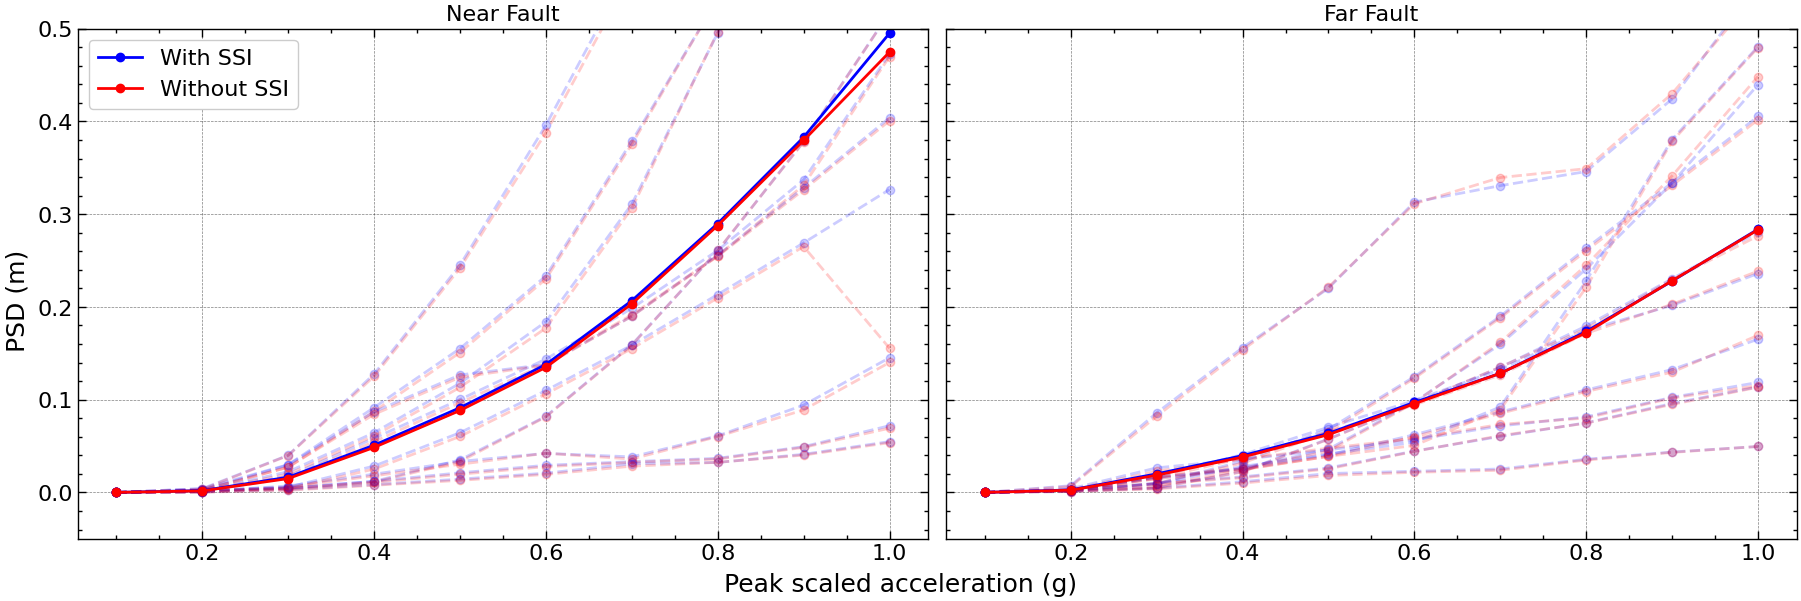

In [218]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in psd_nf.items():
    ax1.plot(factors, arr, 'bo--', label = 'With SSI', alpha = 0.2)
    ax1.plot(factors, ssi_psd_nf[k], 'ro--', label = 'With SSI', alpha = 0.2)
ax1.plot(factors, pd.DataFrame(psd_nf).mean(axis=1), 'bo-', label = 'With SSI')
ax1.plot(factors, pd.DataFrame(ssi_psd_nf).mean(axis=1), 'ro-', label = 'Without SSI')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[-2], handles[-1]], [labels[-2], labels[-1]])
ax1.set_ylim([-0.05,0.5])
for k, arr in psd_ff.items():
    ax2.plot(factors, arr, 'bo--', label = 'With SSI', alpha = 0.2)
    ax2.plot(factors, ssi_psd_ff[k], 'ro--', label = 'Without SSI', alpha = 0.2)
ax2.plot(factors, pd.DataFrame(psd_ff).mean(axis=1), 'bo-', label = 'With SSI')
ax2.plot(factors, pd.DataFrame(ssi_psd_ff).mean(axis=1), 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([-0.05,0.5])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('PSD (m)', fontsize = 18)
# fig.suptitle('Effect of SSI on PSD across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'ssi_psd.{fig_format}'))
# plt.clf()
# plt.close()

In [222]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
ax.plot(factors, pd.DataFrame(psd_nf).mean(axis=1), 'bo-', label = 'With SSI')
ax.plot(factors, pd.DataFrame(ssi_psd_nf).mean(axis=1), 'ro-', label = 'Without SSI')
plt.close()

In [217]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
# resid_nf = np.abs(resid_nf)
# resid_ff = np.abs(resid_ff)
# ssi_resid_nf = np.abs(ssi_resid_nf)
# ssi_resid_ff = np.abs(ssi_resid_ff)
for k, arr in resid_nf.items():
    ax1.plot(factors, np.abs(arr), 'bo--', label = 'With SSI', alpha = 0.2)
    ax1.plot(factors, np.abs(ssi_resid_nf[k]), 'ro--', label = 'Without SSI', alpha = 0.2)
ax1.plot(factors, pd.DataFrame(resid_nf).abs().mean(axis=1), 'bo-', label = 'With SSI')
ax1.plot(factors, pd.DataFrame(ssi_resid_nf).abs().mean(axis=1), 'ro-', label = 'Without SSI')
handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
ax1.legend([handles[-2], handles[-1]], [labels[-2], labels[-1]])
ax1.set_ylim([-0.05,0.5])
for k, arr in resid_ff.items():
    ax2.plot(factors, np.abs(arr), 'bo--', label = 'With SSI', alpha = 0.2)
    ax2.plot(factors, np.abs(ssi_resid_ff[k]), 'ro--', label = 'Without SSI', alpha = 0.2)
ax2.plot(factors, pd.DataFrame(psd_ff).abs().mean(axis=1), 'bo-', label = 'With SSI')
ax2.plot(factors, pd.DataFrame(ssi_psd_ff).abs().mean(axis=1), 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([-0.05,0.5])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('Residual displacement (m)', fontsize = 18)
# fig.suptitle('Effect of SSI on residual displacement across PGAs', fontsize = 18)
fig.savefig(os.path.join(dest, f'ssi_resid.{fig_format}'))
plt.clf()
plt.close()

Shear wave velocity

In [98]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in vs_drift_nf.items():
    ax1.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax1.plot(factors, ssi_drift_nf[k], 'ro-', label = 'Without SSI')
# handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
# ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([0.0265,0.047])
for k, arr in vs_drift_ff.items():
    ax2.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax2.plot(factors, ssi_drift_ff[k], 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([0.0265,0.047])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('IDR (%)', fontsize = 18)
fig.suptitle('Effect of soil shear wave velocity on IDR at 0.6g PGA', fontsize = 18)
fig.savefig(os.path.join(dest, f'vs_idr.{fig_format}'))
plt.clf()
plt.close()

In [99]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in vs_acc_nf.items():
    ax1.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax1.plot(factors, ssi_drift_nf[k], 'ro-', label = 'Without SSI')
# handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
# ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([2.2,4.0])
for k, arr in vs_acc_ff.items():
    ax2.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax2.plot(factors, ssi_drift_ff[k], 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([2.2,4.0])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('Roof Acceleration (m/s$^2$)', fontsize = 18)
fig.suptitle('Effect of soil shear wave velocity on roof acceleration at 0.6g PGA', fontsize = 18)
fig.savefig(os.path.join(dest, f'vs_acc.{fig_format}'))
plt.clf()
plt.close()

In [100]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in vs_psd_nf.items():
    ax1.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax1.plot(factors, ssi_drift_nf[k], 'ro-', label = 'Without SSI')
# handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
# ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
# ax1.set_ylim([2.2,4.0])
for k, arr in vs_psd_ff.items():
    ax2.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax2.plot(factors, ssi_drift_ff[k], 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
# ax2.set_ylim([2.2,4.0])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('PSD (m)', fontsize = 18)
fig.suptitle('Effect of soil shear wave velocity on PSD at 0.6g PGA', fontsize = 18)
fig.savefig(os.path.join(dest, f'vs_psd.{fig_format}'))
plt.clf()
plt.close()

In [101]:
fig = plt.figure(figsize = fig_size, constrained_layout = True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1)
for k, arr in vs_resid_nf.items():
    ax1.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax1.plot(factors, ssi_drift_nf[k], 'ro-', label = 'Without SSI')
# handles, labels = ax1.get_legend_handles_labels()
# ax1.set_ylabel('IDR (%)')
# ax1.set_xlabel('Peak scaled acceleration (g)')
ax1.set_title('Near Fault')
# ax1.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
ax1.set_ylim([-0.55,0.4])
for k, arr in vs_resid_ff.items():
    ax2.plot(velocities, arr, 'bo-', label = 'With SSI')
    # ax2.plot(factors, ssi_drift_ff[k], 'ro-', label = 'Without SSI')
# ax2.set_ylabel('IDR (%)')
# ax2.set_xlabel('Peak scaled acceleration (g)')
ax2.set_title('Far Fault')
ax2.set_ylim([-0.55,0.4])
ax2.label_outer()
fig.supxlabel('Peak scaled acceleration (g)', fontsize = 18)
fig.supylabel('PSD (m)', fontsize = 18)
fig.suptitle('Effect of soil shear wave velocity on residual displacement at 0.6g PGA', fontsize = 18)
fig.savefig(os.path.join(dest, f'vs_resid.{fig_format}'))
plt.clf()
plt.close()

Eigenvalue analysis

In [58]:
velocities = [100, 150, 200, 250, 300, 350, 400, 5000]

In [59]:
# eq_name = 'imp_valley_cc'
eq_type = 'far_fault'
#if not os.path.exists(eq_name):
    # os.mkdir(eq_name)
# file_name = eq_name + '.csv'

In [60]:
eq_df = pd.read_csv(os.path.join(eq_type, 'summary_eq.csv'))

In [61]:
damped_freq = np.zeros(len(velocities))
nat_freq = np.zeros(len(velocities))
second_mode = np.zeros(len(velocities))
for i, vel in enumerate(velocities):
    kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vel, rho)
    K[2,2] = kh
    K[3,3] = kp
    C[2,2] = ch
    C[3,3] = cp
    A[4:, 4:] = - M_inv @ C 
    A[4:, :4] = - M_inv @ K
    vals = np.linalg.eigvals(A)
    mod = np.abs(vals)
    min_index = np.argmin(mod)
    sorted_mod = np.sort(mod)
    print(vals)
    print(mod)
    print(sorted_mod)
    second_idx = np.where(mod == sorted_mod[2])[0][0]
    print(second_idx)
    second_mode[i] = mod[second_idx] / (2*np.pi)
    damped_freq[i] = vals[min_index].imag / (2*np.pi)
    nat_freq[i] = mod[min_index] / (2*np.pi) 

[-5.73444476e+02+0.00000000e+00j -1.04388331e+01+1.02164356e+02j
 -1.04388331e+01-1.02164356e+02j -6.65071010e-11+6.28317935e-02j
 -6.65071010e-11-6.28317935e-02j -9.72856628e+01+0.00000000e+00j
 -7.81114893e+01+0.00000000e+00j -6.16457304e+01+0.00000000e+00j]
[5.73444476e+02 1.02696275e+02 1.02696275e+02 6.28317935e-02
 6.28317935e-02 9.72856628e+01 7.81114893e+01 6.16457304e+01]
[6.28317935e-02 6.28317935e-02 6.16457304e+01 7.81114893e+01
 9.72856628e+01 1.02696275e+02 1.02696275e+02 5.73444476e+02]
7
[-8.62718996e+02+0.00000000e+00j -9.36003778e+00+1.02672642e+02j
 -9.36003778e+00-1.02672642e+02j -2.11501895e-11+6.28318156e-02j
 -2.11501895e-11-6.28318156e-02j -1.45928663e+02+0.00000000e+00j
 -1.15911068e+02+0.00000000e+00j -9.24684264e+01+0.00000000e+00j]
[8.62718996e+02 1.03098408e+02 1.03098408e+02 6.28318156e-02
 6.28318156e-02 1.45928663e+02 1.15911068e+02 9.24684264e+01]
[6.28318156e-02 6.28318156e-02 9.24684264e+01 1.03098408e+02
 1.03098408e+02 1.15911068e+02 1.45928663e+02 

In [62]:
damped_freq

array([0.00999999, 0.00999999, 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      ])

In [63]:
nat_freq

array([0.00999999, 0.00999999, 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      ])

In [64]:
second_mode

array([ 9.81122272, 14.71680714, 16.46093862, 16.49576946, 16.5186449 ,
       16.53402891, 16.54470498, 16.58287899])

Detailed earthquake study for two FF earthqiuakes: 